訓練模型

In [149]:
#%%
import tensorflow as tf
from keras.models import Sequential
from keras.models import load_model, save_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, Callback

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import joblib
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import os

#載入訓練資料
device = 'L4'
SourceData = pd.read_csv(f"..//Data//MergedSorted//{device}_Merged_Sorted.csv")


In [150]:
one_hot_encode_features = [
    'Day',
    'Hour',
    'Minute',
]

input_features_model_1 = to_predict_features_model_1 = [
    
    'Avg_Temperature(°C)',
    'Avg_Humidity(%)',
    'Avg_Sunlight(Lux)',
    # 'Avg_Power(mW)',
    
    'Min_Temperature(°C)',
    'Min_Humidity(%)',
    'Min_Sunlight(Lux)',
    'Min_Power(mW)',
    
    'Max_Temperature(°C)',
    'Max_Humidity(%)',
    'Max_Sunlight(Lux)',
    'Max_Power(mW)',
    
    'Avg_Diff_Temperature(°C)',
    'Avg_Diff_Humidity(%)',
    'Avg_Diff_Sunlight(Lux)',
    
    'Min_Diff_Temperature(°C)',
    'Min_Diff_Humidity(%)',
    'Min_Diff_Sunlight(Lux)',
    'Min_Diff_Power(mW)',
    
    'Max_Diff_Temperature(°C)',
    'Max_Diff_Humidity(%)',
    'Max_Diff_Sunlight(Lux)',
    'Max_Diff_Power(mW)'
]

In [151]:
def create_dataset(data, LookBackNum):
    X = []
    y = []

    #設定每i-12筆資料(X_train)就對應到第i筆資料(y_train)
    for i in range(LookBackNum,len(data)):
        X.append(data[i-LookBackNum:i, :])
        y.append(data[i, :])

    return np.array(X), np.array(y)
  
#設定LSTM往前看的筆數和預測筆數
n_timesteps = LookBackNum = 48 #LSTM往前看的筆數，一筆10分鐘

TrainData = SourceData[to_predict_features_model_1 + one_hot_encode_features].dropna()
TrainData_encode = pd.get_dummies(TrainData, columns=one_hot_encode_features)

#LSTM 選擇要留下來的資料欄位


#正規化
scaler = MinMaxScaler()

exp_transformer = FunctionTransformer(np.expm1, validate=True, inverse_func=np.log1p)

X_preprocess_pipe = make_pipeline(
    scaler,
    # exp_transformer,
    # PCA(n_components=11),
)

y_preprocess_pipe = make_pipeline(
    scaler,
)

X_preprocess_pipe.fit(TrainData_encode)
TrainData_encode[to_predict_features_model_1] = X_preprocess_pipe.transform(TrainData_encode[to_predict_features_model_1])

y_preprocess_pipe.fit(TrainData_encode[to_predict_features_model_1])
AllOutPut_y_Scaled = y_preprocess_pipe.transform(TrainData_encode[to_predict_features_model_1])


X_train, _ = create_dataset(TrainData_encode.values, LookBackNum=LookBackNum)
_, y_train = create_dataset(AllOutPut_y_Scaled, LookBackNum=LookBackNum)

n_features = X_train.shape[2]
n_prediction = y_train.shape[1]

# Reshaping
#(samples 是訓練樣本數量,timesteps 是每個樣本的時間步長,features 是每個時間步的特徵數量)
X_train = np.reshape(X_train,(X_train.shape[0], n_timesteps, n_features))
X_train.shape

(5371, 48, 71)

In [107]:

#%%
#============================建置&訓練「LSTM模型」============================
#建置LSTM模型

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,     # 衰減率
    patience=10,    
    min_lr=1e-9
    )

def build_lstm_model(n_timesteps, n_features, n_prediction):
    model = Sequential()

   
    model.add(LSTM(units=256, return_sequences=True, activation='tanh', input_shape=(n_timesteps, n_features)))

    
    # model.add(LSTM(units=256, return_sequences=True, activation='tanh'))
    # model.add(Dropout(0.2))

   
    model.add(LSTM(units=256, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))

    
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))

    
    model.add(Dense(units=n_prediction))

    
    model.compile(
        optimizer=Adam(learning_rate=7e-4),
        loss='mse',
        metrics=['mae', 'mse']
    )
    model.summary()
    return model

regressor = build_lstm_model(n_timesteps, n_features, n_prediction)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 48, 256)           285696    
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 22)                2838      
                                                                 
Total params: 846,742
Trainable params: 846,742
Non-tr

In [108]:
#開始訓練

history = regressor.fit(
    X_train, 
    y_train, 
    epochs = 100, 
    batch_size = 32,
    validation_split=0.2,
    callbacks=[reduce_lr],
    )

Epoch 1/100
135/135 [==============================] - 5s 18ms/step - loss: 0.0301 - mae: 0.1218 - mse: 0.0301 - val_loss: 0.0112 - val_mae: 0.0687 - val_mse: 0.0112 - lr: 0.0010
Epoch 2/100
135/135 [==============================] - 2s 12ms/step - loss: 0.0136 - mae: 0.0824 - mse: 0.0136 - val_loss: 0.0093 - val_mae: 0.0614 - val_mse: 0.0093 - lr: 0.0010
Epoch 3/100
135/135 [==============================] - 2s 13ms/step - loss: 0.0112 - mae: 0.0722 - mse: 0.0112 - val_loss: 0.0082 - val_mae: 0.0553 - val_mse: 0.0082 - lr: 0.0010
Epoch 4/100
135/135 [==============================] - 2s 13ms/step - loss: 0.0099 - mae: 0.0667 - mse: 0.0099 - val_loss: 0.0082 - val_mae: 0.0526 - val_mse: 0.0082 - lr: 0.0010
Epoch 5/100
135/135 [==============================] - 2s 12ms/step - loss: 0.0091 - mae: 0.0627 - mse: 0.0091 - val_loss: 0.0095 - val_mae: 0.0646 - val_mse: 0.0095 - lr: 0.0010
Epoch 6/100
135/135 [==============================] - 2s 13ms/step - loss: 0.0088 - mae: 0.0603 - mse: 0

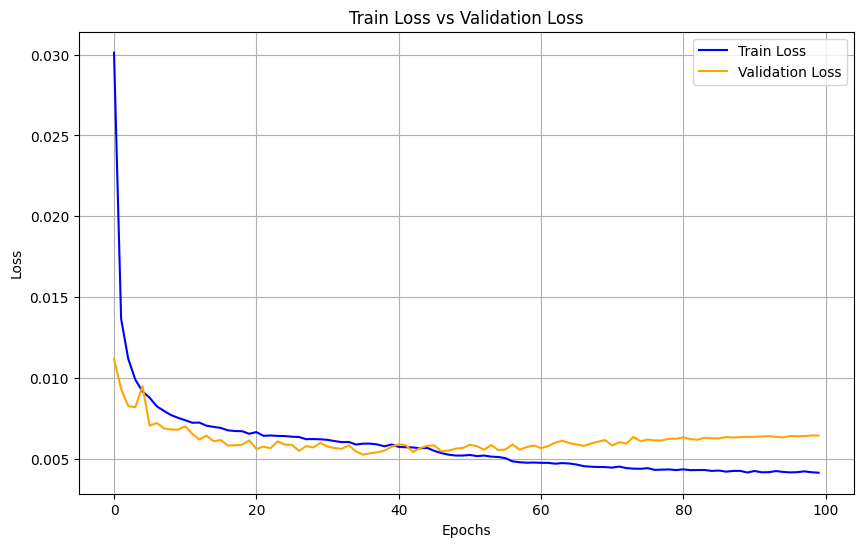

In [109]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
#保存模型
model_path = f'..//Model//WheatherLSTM_{device}.h5'
regressor.save(model_path)
print('Model Saved')

Model Saved


In [111]:
#載入模型
model = load_model(model_path, compile=False)
print('Model Loaded Successfully')

Model Loaded Successfully


In [157]:
PredictedData = SourceData[['SeqNumber'] + to_predict_features_model_1 + one_hot_encode_features]
PredictedData = pd.get_dummies(PredictedData, columns=one_hot_encode_features)

In [112]:


TestData = pd.read_csv('..//Data/TestData//upload(no answer).csv')

TestData = TestData[TestData['序號'] % 100 == int(device[1:])]

to_predict_sequmber = TestData['序號'].to_list()

# 預測的資料 的 index
indices_1 = PredictedData[PredictedData['SeqNumber'].isin(to_predict_sequmber)][to_predict_features_model_1].index.to_list()
len(indices_1)

384

In [113]:
index_min = min(indices_1) - n_timesteps
index_max = max(indices_1)

indices_2 = PredictedData.loc[index_min:index_max][to_predict_features_model_1].index.tolist()

# 找出有 NaN 的 row
rows_with_na = PredictedData.loc[indices_2, to_predict_features_model_1].isnull().any(axis=1)
rows_with_na_data = PredictedData.loc[indices_2, to_predict_features_model_1][rows_with_na]

# 有 NaN 的 row 的 index
indices_with_na =  rows_with_na_data.index.to_list()
len(indices_with_na)

6612

In [114]:
 # 如果 LookBackNum > 12 選 indices_with_na
 # 其餘選 indices_1
indices_to_use = []
if LookBackNum > 12:
    indices_to_use = indices_with_na
else:
    indices_to_use = indices_1

for index in indices_to_use:
    X = PredictedData.drop(columns='SeqNumber')
    X[to_predict_features_model_1] = X_preprocess_pipe.transform(X[to_predict_features_model_1])
    X = X.values
    X = np.reshape(X,(1, n_timesteps, n_features))
    pred = model.predict(X)
    pred[to_predict_features_model_1] = X_preprocess_pipe.inverse_transform(pred[to_predict_features_model_1])
    PredictedData.loc[index, to_predict_features_model_1] = pred

1/1 [==============================] - 0s 22ms/step


In [115]:
PredictedData.loc[indices_1][['SeqNumber'] + to_predict_features_model_1].to_csv(f'..//Data//PredictedData//Predicted_{device}.csv', index=False)

In [116]:
TrainData = pd.read_csv(f'..//Data//MergedSorted//{device}_Merged_Sorted.csv')

TrainData.dropna(inplace=True)
TrainData.reset_index(inplace=True)

input_features = to_predict_features_model_1

to_predict_features = [
    'Avg_Power(mW)',
    ]

In [117]:

# 訓練 迴歸模型
X_full = TrainData[to_predict_features_model_1].values
y_full = TrainData[to_predict_features].values

X_train, X_val, y_train, y_val = train_test_split(X_full,y_full,test_size=0.2,shuffle=True)

reg_model = make_pipeline(
    MinMaxScaler(),
    PCA(n_components=19),
    PolynomialFeatures(degree=2),
    LinearRegression(),
)

cv_scores = cross_val_score(reg_model, X_train, y_train, cv=20)
cv_scores

array([0.99713859, 0.99511206, 0.99701512, 0.99641165, 0.99491581,
       0.99597724, 0.99652988, 0.99673458, 0.99701475, 0.96189605,
       0.99580339, 0.99484507, 0.98047813, 0.99326969, 0.98882081,
       0.99439215, 0.99412251, 0.99266606, 0.99695375, 0.99597501])

In [118]:
reg_model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=19)),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg_model.predict(X_val)
y_pred = y_pred = np.clip(y_pred, 0, None)

print('MSE: ',mean_squared_error(y_val, y_pred))
print('MAE: ',mean_absolute_error(y_val, y_pred))
print('R2:',r2_score(y_val, y_pred))

MSE:  1047.081802909906
MAE:  14.389293667800064
R2: 0.9954463625125133


In [120]:
reg_model.fit(X_full, y_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=19)),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [121]:
# 預測 發電量
PredictedData = pd.read_csv(f'..//Data//PredictedData//Predicted_{device}.csv')

X_Test = PredictedData[to_predict_features_model_1].values

y_pred = reg_model.predict(X_Test)
y_pred = np.clip(y_pred, 0, None)
PredictedData[to_predict_features] = y_pred
PredictedData.to_csv(f'..//Data//PredictedData//Predicted_{device}.csv', index=False)

In [122]:
PredictedData[['Min_Power(mW)','Avg_Power(mW)','Max_Power(mW)']]

,Min_Power(mW),Avg_Power(mW),Max_Power(mW)
0,322.487579,369.148352,462.835999
1,270.916962,328.578253,438.097351
2,284.048401,325.165149,405.994537
3,285.357819,323.925943,391.623596
4,285.881836,356.042152,466.257416
...,...,...,...
379,265.099731,334.650716,413.079651
380,285.858093,358.196750,437.938904
381,309.176086,385.026336,466.677795
382,335.213074,414.566353,498.017487
